In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [195]:
import np2d
import numpy as np
import pandas as pd
import networkx as nx
import itertools as it

from latticeproteins.conformations import ConformationList, Conformations
from latticeproteins.thermodynamics import LatticeThermodynamics
from latticeproteins.sequences import find_differences, _residues, random_sequence

In [143]:
class PredictedLattice(object):
    """Infers the stability and fraction folded of any sequence with respect
    to some wildtype lattice model using a linear, biochemical epistasis model.
    Calculates the independent effect of all mutations (and pairwise effects
    if `double` is True) and sums those effects to predict other sequences.

    Parameters
    ----------
    wildtype : str
        wildtype/ancestral sequence
    temp : float
        temperature in reduced units
    confs : list
        list of conformations
    double : bool
        if True, include pairwise epistasis when inferring stability.
    """
    def __init__(self, wildtype, temp, confs, target=None):
        self.wildtype = wildtype
        self.temp = temp
        self.conformations = confs
        self.target = target
        self._lattice = LatticeThermodynamics(self.temp, self.conformations)

        combos = []
        sites = list(range(self.conformations.length()))
        self.dG0 = self._lattice.stability(self.wildtype, target=self.target)

        #####  Build a dictionary of additive and pairwise mutational effects ####
        # Calculate first order coefs
        self.dGs = {}
        for i in sites:
            other_sites = sites[:]
            other_sites.remove(i)
            for aa in _residues:
                combos.append((i, aa))

        for c in combos:
            seq = list(self.wildtype[:])
            seq[c[0]] = c[1]
            # Calculate dG as dG_wt -
            self.dGs[c] = self._lattice.stability(seq, target=self.target) - self.dG0

        # Calculate second order coefs
        combos = []
        sites = list(range(self.conformations.length()))
        for i in sites:
            other_sites = sites[:]
            other_sites.remove(i)
            for aa in _residues:
                for j in other_sites:
                    for aa2 in _residues:
                        combos.append((i,aa,j,aa2))

        for c in combos:
            seq = list(self.wildtype[:])
            seq[c[0]] = c[1]
            seq[c[2]] = c[3]
            # Calculate dG2
            self.dGs[c] = self._lattice.stability(seq, target=self.target) - (self.dG0 + self.dGs[(c[0],c[1])]+ self.dGs[(c[2],c[3])])

    def stability(self, seq, target=None, double=True):
        """Calculate the stability of a given sequence using the Lattice predictor"""
        # Get additive coefs to build predictions
        if target != self.target:
            raise Exception("Target does not match wildtype target.")
        loci = find_differences(self.wildtype, seq)
        
        # Get all additive combinations for the sequence given
        add = [(pair[0], seq[pair[0]]) for pair in it.combinations(loci, 1)]
        
        if double:
            # Get all pairwise effects for the sequence given
            pairs = [(pair[0], seq[pair[0]], pair[1], seq[pair[1]]) for pair in it.combinations(loci, 2)]
            dgs = add + pairs
        else:
            dgs = add
        
        # Get the wildtype stability
        stability = float(self.dG0)
        
        # Sum the mutational effects
        for coef in dgs:
            stability += self.dGs[coef]
        return stability

    def fracfolded(self, seq, target=None):
        """Calculate the fraction folded for a given sequence"""
        return 1.0 / (1.0 + np.exp(self.stability(seq, target=target) / self.temp))


In [283]:
def fixation(fitness1, fitness2, popsize=np.inf, *args, **kwargs):
    """ Simple Gillespie fixation probability between two organism with fitnesses 1 and 2.
    (With infinite population size!)

    .. math::
        p_{\\text{fixation}} = \\frac{1 - e^{-N \\frac{f_2-f_1}{f1}}}{1 - e^{-\\frac{f_2-f_1}{f1}}}
    """
    sij = (fitness2 - fitness1)/abs(fitness1)
    # Check if any nans exist if an array of fitnesses is given.
    fixation = (1 - np.exp(-sij)) / (1 - np.exp(-popsize*sij))
    return  fixation

In [284]:
def overlap(p,q):
    """Calculates the difference in overlap."""
    return np.array(abs(p - q)).sum() / (p.sum() + q.sum())

In [285]:
def build_M_fixation(anc, lattice, target, popsize=np.inf):
    """Construct a transiton matrix for a given lattice sequence."""
    # Calculate 
    seq = list(anc)
    fitness_ref = lattice.fracfolded(seq, target=target)
    
    # Zip site number to site
    index = tuple(zip(range(len(anc)), anc))
    M_fitness = pd.DataFrame(index=index, columns=_residues, dtype=float)
    
    # Fit in fitnesses
    for AA in M_fitness.columns:
        for i, site in M_fitness[AA].index:
            seq2 = seq[:]
            seq2[i] = AA
            M_fitness[AA][(i,site)] = lattice.fracfolded(seq2, target=target)
            
    # Calculate a transition matrix
    M_fixation = fixation(fitness_ref, M_fitness, popsize=popsize)
    M_fixation.fillna(0, inplace=True)
    return M_fixation

In [294]:
anc

'PFLHTG'

In [291]:
anc = "".join(random_sequence(6))
length = len(anc)
n_moves = 7
n_branches = 3
n_states = 3
popsize = np.inf

######### NEED COMMENT
true_trajectories = {i : {} for i in range(1, n_moves+1)}
true_trajectories[0] = {(anc,): 1}

######### NEED COMMENT
pred_trajectories = {i : {} for i in range(1, n_moves+1)}
pred_trajectories[0] = {(anc,): 1}


db = ['URRDL', 'UURDD', 'URDRU', 'URDDL']
c = db[0:n_states]
target = db[0]
confs = ConformationList(length, c)
#confs = Conformations(length)

# True lattice model
true_lattice = LatticeThermodynamics(1.0, confs)
#target = lattice.native_conf(anc)

# Predicted lattice model
pred_lattice = PredictedLattice(anc, 1.0, confs, target=target)

# Construct trajectories.
for ith_move in range(1,n_moves+1):

    # Get current moves to explore
    true_current = true_trajectories[ith_move-1]
    pred_current = pred_trajectories[ith_move-1]
    
    for traj in true_current:
        # Get current fixation probability
        true_pi = true_current[traj]
        pred_pi = pred_current[traj]
        
        # Get last (current) sequence in trajectory
        der = traj[-1]

        # Fixation matrix
        M_fixation = build_M_fixation(der, true_lattice, target=target, popsize=popsize)

        # normalize to get transition matrix
        M_transition = M_fixation / M_fixation.sum().sum()

        # Breaks if 3 moves are not possible
        try:
            # Sample moves, if moves are not possible, break
            transitions, ilocs = np2d.random.choice(M_transition, size=n_branches, replace=False, p=M_transition)
            
            # Construct new sequences
            new_sequences = []
            for ith, iloc in enumerate(ilocs):
                site = M_fixation.index[iloc[0]][0]
                mutation = M_fixation.columns[iloc[1]]
                seq = list(der)
                seq[site] = mutation
                seq_ = "".join(seq)
                new_sequences.append(seq_)
                
            # Calculate the probabilities of fixation for true trajectories.
            true_ff = true_lattice.fracfolded(der, target=target)
            true_ffs = np.array([true_lattice.fracfolded(seq, target=target) for seq in new_sequences])
            true_fixations = fixation(true_ff, true_ffs, popsize=popsize)
            true_norm = true_fixations.sum()
            
            # Calculate the probabilities of fixation for predicted trajectories.
            pred_ff = pred_lattice.fracfolded(der, target=target)
            pred_ffs = np.array([pred_lattice.fracfolded(seq, target=target) for seq in new_sequences])
            pred_fixations = fixation(pred_ff, pred_ffs, popsize=popsize)
            pred_norm = pred_fixations.sum()
            
            # Add new sequences to trajectories and fixations
            for ith, seq_ in enumerate(new_sequences):
                traj_ = traj + (seq_,)

                # True trajectories
                true_trajectories[ith_move][traj_] = true_pi * true_fixations[ith] / true_norm
                
                # Predicted trajectories
                pred_trajectories[ith_move][traj_] = pred_pi * pred_fixations[ith] / pred_norm

        # If there are not 3 possible moves, 
        except ValueError: continue 

/Users/Zsailer/miniconda3/envs/ensembles/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars


In [292]:
theta = []
for ith_move in range(1, n_moves+1):
    p, q = [], []
    for traj in pred_trajectories[ith_move]:
        p.append(true_trajectories[ith_move][traj])
        q.append(pred_trajectories[ith_move][traj])
    theta.append(overlap(np.array(p),np.array(q)))


In [295]:
target

'URRDL'

[1, 7, -0.05, 1.05]

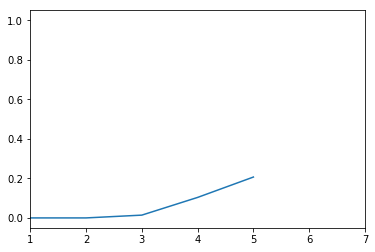

In [293]:
plt.plot(range(1,n_moves+1), theta)
plt.axis([1,7,-0.05,1.05])

In [272]:
    parser = argparse.ArgumentParser(description=__doc__)
    parser.add_argument("i", type=str, help="dataset number (for book-keeping).")
    parser.add_argument("anc", type=str, help="ancestral sequence to evolve from.")
    parser.add_argument("--db", nargs=3, help="conformation database.", type=str)
    parser.add_argument("--target", help="target structure.", type=str)
    parser.add_argument("--popsize", help="population size", type=int)
    parser.add_argument("--n_moves", type=int, help="number of mutations.")
    parser.add_argument("--n_branches", type=int, help="number of branches")
    parser.add_argument("--n_states", type=int, help="Number of states in ensemble. 0 means all states.")
    args = parser.parse_args()

[0.0, 0.0, 0.12677343482982181, 0.25302934609764799, 0.31325817100666481]